### Check inconsistencies with the data

Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 1093705.19rows/s]


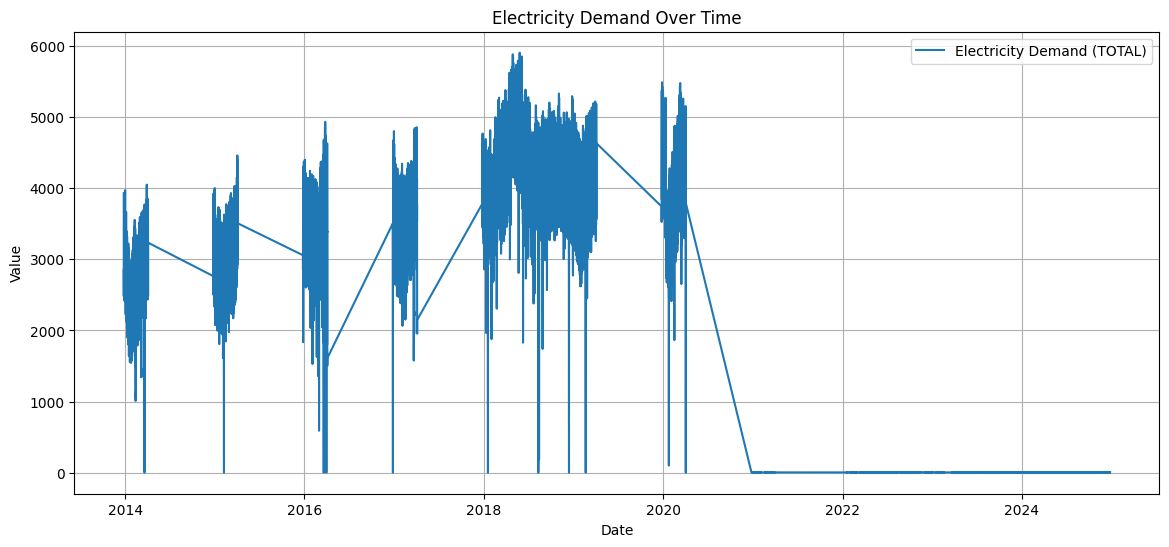

In [3]:
# Plot Electricity Demand (TOTAL) from demand csv

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "tmp/Demand.csv"
chunksize = 10_000  

# Count rows first (excluding header)
with open(file_path) as f:
    total_rows = sum(1 for _ in f) - 1


# Load with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# --- Handle different formats ---
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")
    df.set_index("DateTime", inplace=True)
elif "Metering Point" in df.columns:
    df["Metering Point"] = pd.to_datetime(df["Metering Point"], format="mixed", errors="coerce")
    df.set_index("Metering Point", inplace=True)


# Drop unnamed index column if exists
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")

# Plot Temperature only if it exists
if "Temperature" in df.columns:
    plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)

plt.title("Electricity Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 910361.98rows/s]


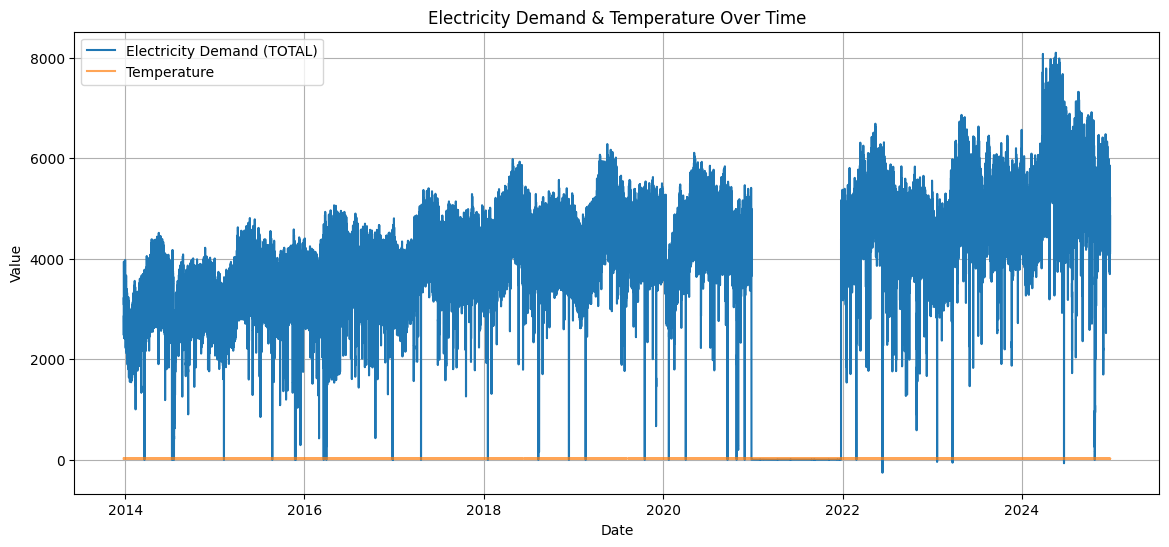

In [4]:
# Plot Demand and temp from Demand_with_Temperature.csv before fixing inconsistency from demand
# There's a period from the demand that was not converted to Kilowatts from Megawatts

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "tmp/Demand_with_Temperature.csv"
chunksize = 10_000  

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# Fix the inconsistency from the demand
# Convert the period from december 26, 2020 - december 25, 2021 from Megawatts to Kilowatts

import pandas as pd

# Load CSV
file_path = "tmp/Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime column is parsed properly
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Define range
start = pd.Timestamp("2020-12-26 00:00:00")
end = pd.Timestamp("2021-12-25 23:55:00.000")

# Multiply TOTAL by 1000 in that range
mask = (df["DateTime"] >= start) & (df["DateTime"] <= end)
df.loc[mask, "TOTAL"] = df.loc[mask, "TOTAL"] * 1000

# Save to new CSV
output_file = "Demand_with_Temperature.csv"
df.to_csv(output_file, index=False)

print(f"Saved modified CSV to {output_file}")


Saved modified CSV to Demand_with_Temperature.csv


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 949973.44rows/s]


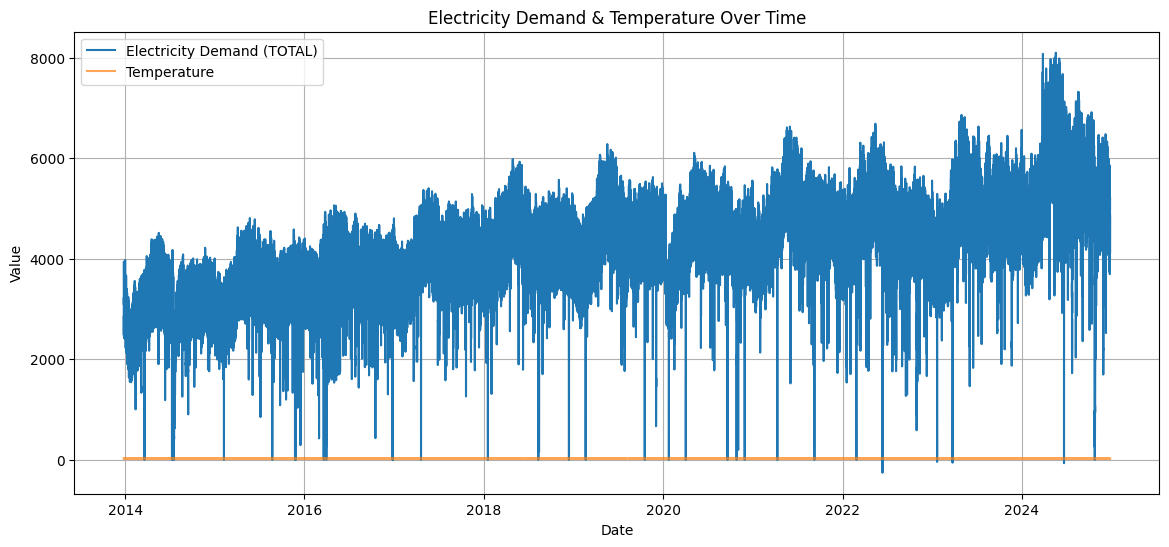

In [6]:
# Plot the new data to see if the inconsistencies were gone

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Check dates that experienced power outage

import pandas as pd

# Load CSV
file_path = "Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime is datetime
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Find rows with negative TOTAL
neg_demands = df[df["TOTAL"] <= 0]

print(f"Number of rows with negative demand: {len(neg_demands)}")
if not neg_demands.empty:
    print(neg_demands[["DateTime", "TOTAL"]])


Number of rows with negative demand: 3336
                       DateTime  TOTAL
24265   2014-03-20 07:05:00.000    0.0
24266   2014-03-20 07:10:00.000    0.0
24267   2014-03-20 07:15:00.000    0.0
24268   2014-03-20 07:20:00.000    0.0
24269   2014-03-20 07:25:00.000    0.0
...                         ...    ...
1139258 2024-10-24 19:14:59.976    0.0
1139259 2024-10-24 19:19:59.976    0.0
1139260 2024-10-24 19:24:59.976    0.0
1139261 2024-10-24 19:29:59.976    0.0
1139262 2024-10-24 19:34:59.976    0.0

[3336 rows x 2 columns]


In [8]:
# Fix inconsistency in outage binary indicator

import pandas as pd

# Load CSV
file_path = "Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime is datetime
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Fix Outage based on TOTAL
df["Outage"] = (df["TOTAL"] <= 0).astype(int)

# Optional: check first few rows
print(df[["DateTime", "TOTAL", "Outage"]].head())

# Save updated CSV
df.to_csv("Demand_with_Temperature.csv", index=False)


             DateTime        TOTAL  Outage
0 2013-12-26 01:00:00  2850.352704       0
1 2013-12-26 01:05:00  2740.011311       0
2 2013-12-26 01:10:00  2740.011311       0
3 2013-12-26 01:15:00  2740.011311       0
4 2013-12-26 01:20:00  2740.011311       0


### Check correlation

Check the correlation between "demand" (TOTAL) and "temperature"

                  TOTAL    Outage    Monday   Tuesday  Wednesday  Thursday  \
TOTAL          1.000000 -0.219894  0.013548 -0.010582  -0.004980 -0.008531   
Outage        -0.219894  1.000000 -0.018635 -0.012555  -0.002053  0.019874   
Monday         0.013548 -0.018635  1.000000 -0.166668  -0.166669 -0.166662   
Tuesday       -0.010582 -0.012555 -0.166668  1.000000  -0.166668 -0.166661   
Wednesday     -0.004980 -0.002053 -0.166669 -0.166668   1.000000 -0.166662   
Thursday      -0.008531  0.019874 -0.166662 -0.166661  -0.166662  1.000000   
Friday         0.015202 -0.007673 -0.166669 -0.166668  -0.166669 -0.166662   
Saturday       0.012348  0.018075 -0.166669 -0.166669  -0.166669 -0.166662   
Sunday        -0.017005  0.002967 -0.166669 -0.166668  -0.166669 -0.166662   
Holiday        0.066733 -0.000876 -0.004699  0.010249  -0.010678  0.001288   
ECQ            0.037752 -0.003292 -0.001672 -0.001672  -0.001672 -0.001670   
GCQ            0.147089  0.001201  0.001836 -0.000301  -0.000309

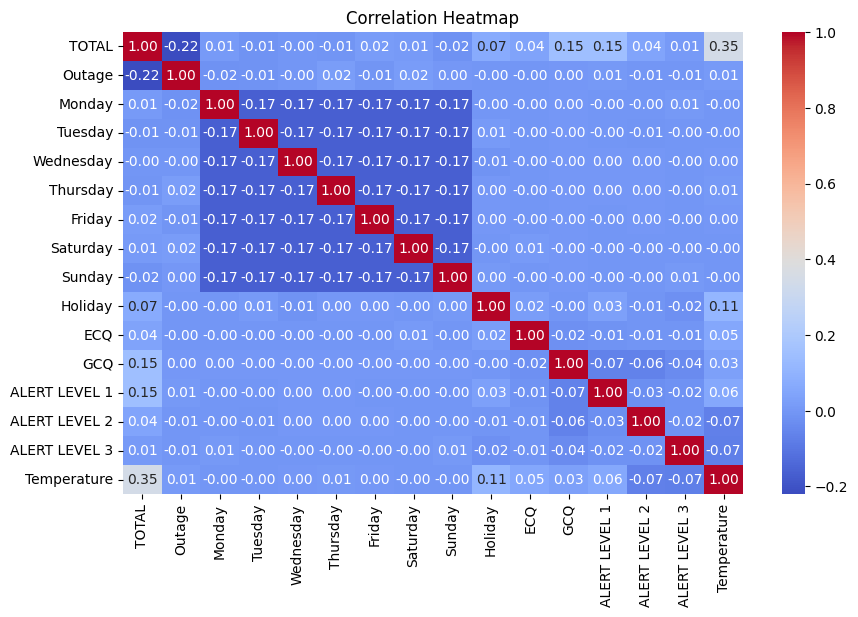

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("Demand_with_Temperature.csv", parse_dates=["DateTime"])

# Compute correlations only for numeric columns
corr = df.corr(numeric_only=True)

# Print the correlation matrix
print(corr)

# Plot heatmap for easier visualization
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### Check inconsistency with the DateTime

In [11]:
# Check invalid rows
import pandas as pd

# Load raw CSV (no parsing yet)
df_raw = pd.read_csv("Demand_with_Temperature.csv")

# Try to parse DateTime
df_raw["ParsedDateTime"] = pd.to_datetime(df_raw["DateTime"], errors="coerce")

# Find problematic rows (where parsing failed → NaT)
invalid_rows = df_raw[df_raw["ParsedDateTime"].isna()]

# Show summary
print(f"Total invalid DateTime rows: {len(invalid_rows)}")

# Display first few invalid rows
print(invalid_rows.head(20))

# Save them to a CSV for inspection
# invalid_rows.to_csv("Invalid_DateTime_Rows.csv", index=False)


Total invalid DateTime rows: 316046
                       DateTime        TOTAL  Outage  Monday  Tuesday  \
841126  2021-12-24 14:50:00.000  4792.022175       0       0        0   
841127  2021-12-24 14:55:00.000  4792.022175       0       0        0   
841128  2021-12-24 15:00:00.000  4741.859891       0       0        0   
841129  2021-12-24 15:05:00.000  4741.859891       0       0        0   
841130  2021-12-24 15:10:00.000  4741.859891       0       0        0   
841131  2021-12-24 15:15:00.000  4741.859891       0       0        0   
841132  2021-12-24 15:20:00.000  4741.859891       0       0        0   
841133  2021-12-24 15:25:00.000  4741.859891       0       0        0   
841134  2021-12-24 15:30:00.000  4741.859891       0       0        0   
841135  2021-12-24 15:35:00.000  4741.859891       0       0        0   
841136  2021-12-24 15:40:00.000  4741.859891       0       0        0   
841137  2021-12-24 15:45:00.000  4741.859891       0       0        0   
841138  2021-12

In [12]:
# Remove milliseconds

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Demand_with_Temperature.csv")

# --- Step 1: Clean the DateTime column as string ---
df["DateTime"] = df["DateTime"].astype(str).str.strip()

# Remove milliseconds if present (anything after ".")
df["DateTime"] = df["DateTime"].str.replace(r"\.\d+$", "", regex=True)

# Replace known invalids
df["DateTime"] = df["DateTime"].replace(["0000-00-00 00:00:00", "NaT", "nan", ""], np.nan)

# --- Step 2: Parse into datetime ---
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

# --- Step 3: Fill invalids ---
df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")

# --- Step 4: Verify if still broken ---
invalid_rows = df[df["DateTime"].isna()]
print(f"Remaining invalid DateTime rows: {len(invalid_rows)}")

# --- Step 5: Save cleaned file ---
df.to_csv("Demand_with_Temperature.csv", index=False)
print("Done")


/tmp/ipykernel_2991806/2250380313.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")


Remaining invalid DateTime rows: 0
Done


In [13]:
# Fix 5 min interval
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Demand_with_Temperature.csv")

# --- Step 1: Parse DateTime safely ---
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# --- Step 2: Fix invalids (forward fill then backfill) ---
df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")

# --- Step 3: Snap to nearest 5-minute interval ---
df["DateTime"] = df["DateTime"].dt.round("5min")

# --- Step 4: Ensure no duplicates (optional, if rounding caused collisions) ---
df = df.drop_duplicates(subset=["DateTime"], keep="first")

# --- Step 5: Save back ---
df.to_csv("Demand_with_Temperature.csv", index=False)

print("DateTime normalized to 5-minute intervals.csv")


/tmp/ipykernel_2991806/3168316187.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")


DateTime normalized to 5-minute intervals.csv


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 904539.86rows/s]


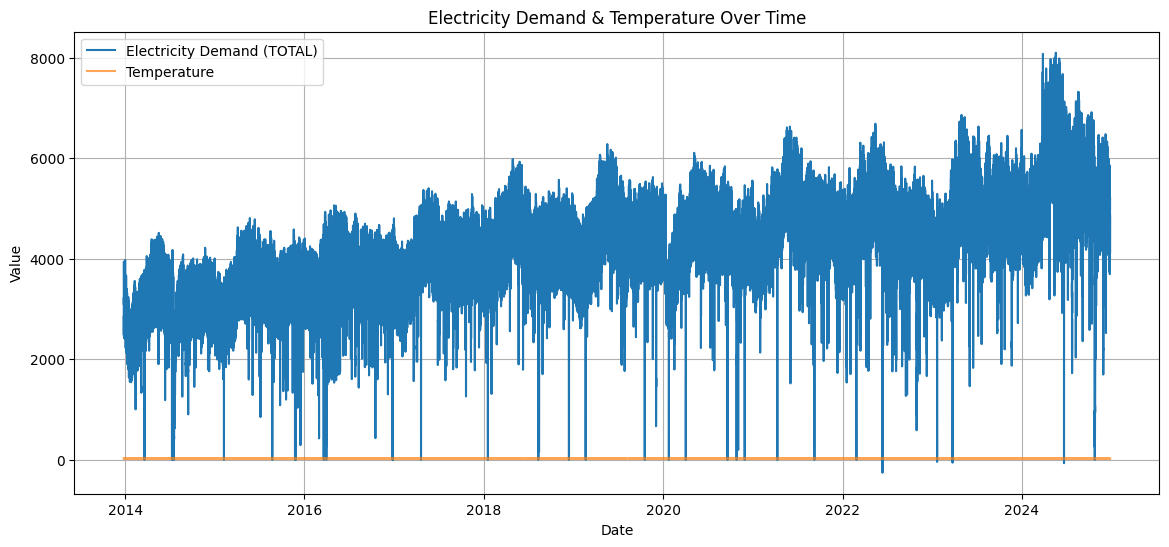

In [15]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Use Kalman Filter for removing outage the dataset

In [26]:
# Analyze outages where TOTAL <= 0 (power outages / invalid readings)

import pandas as pd
import numpy as np

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"  # change if you want a different variant
EXPORT_RUNS_CSV = True
RUNS_OUTPUT = "Outage_Runs.csv"
EXPECTED_STEP = pd.Timedelta(minutes=5)  # used for sanity checking cadence

# --- Load Data ---
df_o = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df_o.empty:
    raise ValueError("Loaded dataframe is empty – check file path.")

df_o = df_o.sort_values("DateTime").reset_index(drop=True)
df_o.set_index("DateTime", inplace=True)

if "TOTAL" not in df_o.columns:
    raise KeyError("Column 'TOTAL' not found in the dataset.")

# --- Basic cadence sanity ---
if len(df_o.index) > 2:
    diffs = (df_o.index[1:] - df_o.index[:-1])
    modal = diffs.to_series().mode()
    dominant = modal.iloc[0] if not modal.empty else None
    if dominant != EXPECTED_STEP:
        print(f"[WARN] Dominant step={dominant}, expected={EXPECTED_STEP}. Outage duration calculations assume 5-minute steps.")

# --- Outage mask (<=0) ---
out_mask = df_o["TOTAL"] <= 0
num_out_rows = int(out_mask.sum())
print(f"Total outage rows (TOTAL <= 0): {num_out_rows}")

if num_out_rows == 0:
    print("No outages detected.")
else:
    # --- Identify contiguous outage runs ---
    # Start of a run where current is True and previous is False
    run_starts = (out_mask & ~out_mask.shift(1, fill_value=False))
    # Cumulative sum of starts gives a run id (0 where mask False)
    run_id = run_starts.cumsum() * out_mask.astype(int)

    outage_rows = df_o.loc[out_mask, ["TOTAL"]].copy()
    outage_rows["run_id"] = run_id[out_mask]

    # Group to summarize each run
    runs = (
        outage_rows
        .groupby("run_id", sort=True)
        .apply(lambda g: pd.Series({
            "start": g.index[0],
            "end": g.index[-1],
            "steps": len(g)
        }))
        .reset_index(drop=True)
    )
    runs["duration_minutes"] = runs["steps"] * (EXPECTED_STEP / pd.Timedelta(minutes=1))
    runs["duration_hours"] = runs["duration_minutes"] / 60.0

    total_minutes = runs["duration_minutes"].sum()
    longest_minutes = runs["duration_minutes"].max()
    longest_run = runs.loc[runs["duration_minutes"].idxmax()] if not runs.empty else None

    print("\nOutage Summary:")
    print(f"  Number of distinct outage episodes: {len(runs)}")
    print(f"  Total outage minutes: {total_minutes:.0f} (~{total_minutes/60:.2f} hours)")
    print(f"  Longest outage: {longest_minutes:.0f} minutes (~{longest_minutes/60:.2f} hours)")
    if longest_run is not None:
        print(f"    Longest run start: {longest_run['start']}")
        print(f"    Longest run end  : {longest_run['end']}")

    # Display first few runs
    print("\nFirst 5 outage episodes:")
    print(runs.head())

    if EXPORT_RUNS_CSV:
        runs.to_csv(RUNS_OUTPUT, index=False)
        print(f"\nSaved outage episodes to {RUNS_OUTPUT}")

    # Optional: create a concise per-timestamp result table (commented out)
    # outage_rows.to_csv("Outage_Rows_Detail.csv")

# Quick integrity check: ensure mask aligns
# (All rows in outage_rows should have TOTAL <= 0 if outages exist)
if num_out_rows > 0 and not (df_o.loc[out_mask, "TOTAL"] <= 0).all():
    print("[WARN] Some rows flagged as outage do not have TOTAL <= 0 – investigate.")
else:
    print("Integrity check passed.")


Total outage rows (TOTAL <= 0): 3336

Outage Summary:
  Number of distinct outage episodes: 31
  Total outage minutes: 16680 (~278.00 hours)
  Longest outage: 3660 minutes (~61.00 hours)
    Longest run start: 2014-07-16 05:00:00
    Longest run end  : 2014-07-18 17:55:00

First 5 outage episodes:
                start                 end  steps  duration_minutes  \
0 2014-03-20 07:05:00 2014-03-20 18:00:00    132             660.0   
1 2014-07-10 10:00:00 2014-07-10 16:55:00     84             420.0   
2 2014-07-16 05:00:00 2014-07-18 17:55:00    732            3660.0   
3 2015-02-07 02:05:00 2015-02-07 10:00:00     96             480.0   
4 2015-08-23 01:00:00 2015-08-23 07:55:00     84             420.0   

   duration_hours  
0            11.0  
1             7.0  
2            61.0  
3             8.0  
4             7.0  

Saved outage episodes to Outage_Runs.csv
Integrity check passed.


/tmp/ipykernel_2991806/1258703471.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [17]:
# use kalman to fix outages
# BUG: There are inconsistencies that isn't solved using  "x <= 0"

import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# --- Load data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Mark outages (TOTAL <= 0) as missing ---
df.loc[df["TOTAL"] <= 0, "TOTAL"] = np.nan

# --- Step 2: Temporary fill for NaNs (linear interpolation) ---
# This just helps Kalman start, Kalman will refine it
observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# --- Step 3: Initialize Kalman Filter ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=observed.iloc[0],
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 4: Fit & smooth ---
smoothed_state_means, _ = kf.em(observed.values, n_iter=5).smooth(observed.values)

# --- Step 5: Replace TOTAL with smoothed values ---
df["TOTAL"] = smoothed_state_means

# --- Step 6: Save cleaned dataset ---
df.to_csv("Demand_with_Temperature_Kalman.csv")

print("Done")

/tmp/ipykernel_2991806/928810277.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")


Done


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 843470.70rows/s]


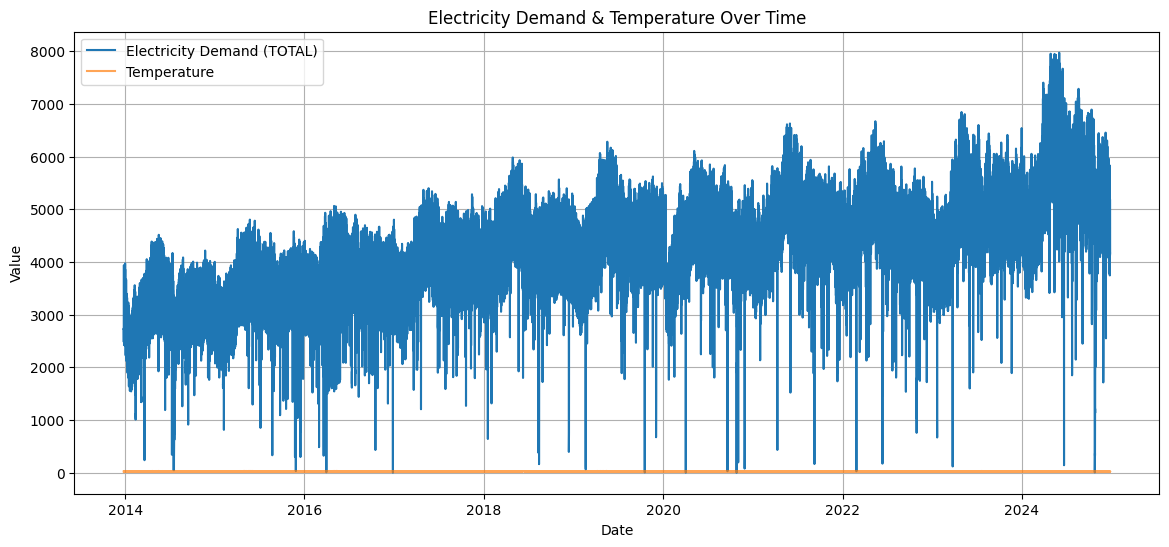

In [18]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature_Kalman.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Sudden drop but didn't meet <=0 or outage

In [28]:
# Detect sudden drops (>=20%) between consecutive 5‑minute readings (non-outage focus)
# Mirrors the outage analysis structure but uses a relative drop mask instead of TOTAL <= 0.

import pandas as pd
import numpy as np

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"  # input dataset
EXPECTED_STEP = pd.Timedelta(minutes=5)     # assumed cadence
DROP_THRESHOLD = 0.20                       # 20% drop
MIN_BASE_VALUE = 1e-6                       # avoid division by ~0
EXPORT_RUNS_CSV = True
RUNS_OUTPUT = "SuddenDrop_Runs.csv"
TOP_N_PRINT = 5

# --- Load Data ---
df_o = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df_o.empty:
    raise ValueError("Loaded dataframe is empty – check file path.")

df_o = df_o.sort_values("DateTime").reset_index(drop=True)
df_o.set_index("DateTime", inplace=True)

if "TOTAL" not in df_o.columns:
    raise KeyError("Column 'TOTAL' not found in the dataset.")

# --- Basic cadence sanity ---
if len(df_o.index) > 2:
    diffs = (df_o.index[1:] - df_o.index[:-1])
    modal = diffs.to_series().mode()
    dominant = modal.iloc[0] if not modal.empty else None
    if dominant != EXPECTED_STEP:
        print(f"[WARN] Dominant step={dominant}, expected={EXPECTED_STEP}. Duration calculations assume 5-minute steps.")

# --- Sudden drop mask ---
total_series = df_o["TOTAL"].astype(float)
prev = total_series.shift(1)
with np.errstate(divide='ignore', invalid='ignore'):
    rel_drop = (prev - total_series) / prev  # positive when current < prev
    rel_drop = rel_drop.where(prev.abs() > MIN_BASE_VALUE, other=0.0)

sudden_mask = (
    prev.notna() & total_series.notna() &  # need valid consecutive points
    (rel_drop >= DROP_THRESHOLD) &         # meets relative threshold
    (prev > total_series)                  # ensure it's actually a drop
)

num_sudden_rows = int(sudden_mask.sum())
print(f"Total sudden-drop rows (>= {DROP_THRESHOLD*100:.1f}%): {num_sudden_rows}")

if num_sudden_rows == 0:
    print("No sudden drops detected at this threshold.")
else:
    # --- Identify contiguous sudden-drop runs ---
    run_starts = (sudden_mask & ~sudden_mask.shift(1, fill_value=False))
    run_id = run_starts.cumsum() * sudden_mask.astype(int)

    sudden_rows = df_o.loc[sudden_mask, ["TOTAL"]].copy()
    sudden_rows["run_id"] = run_id[sudden_mask]
    sudden_rows["rel_drop"] = rel_drop[sudden_mask]
    sudden_rows["abs_drop"] = (prev - total_series)[sudden_mask]

    # Group to summarize each run
    runs = (
        sudden_rows
        .groupby("run_id", sort=True)
        .apply(lambda g: pd.Series({
            "start": g.index[0],
            "end": g.index[-1],
            "steps": len(g),
            "max_rel_drop": g["rel_drop"].max(),
            "mean_rel_drop": g["rel_drop"].mean(),
            "max_abs_drop": g["abs_drop"].max()
        }))
        .reset_index(drop=True)
    )

    runs["duration_minutes"] = runs["steps"] * (EXPECTED_STEP / pd.Timedelta(minutes=1))
    runs["duration_hours"] = runs["duration_minutes"] / 60.0

    total_minutes = runs["duration_minutes"].sum()
    longest_minutes = runs["duration_minutes"].max()
    longest_run = runs.loc[runs["duration_minutes"].idxmax()] if not runs.empty else None

    print("\nSudden Drop Summary:")
    print(f"  Number of distinct sudden-drop episodes: {len(runs)}")
    print(f"  Total sudden-drop minutes: {total_minutes:.0f} (~{total_minutes/60:.2f} hours)")
    print(f"  Longest episode: {longest_minutes:.0f} minutes (~{longest_minutes/60:.2f} hours)")
    if longest_run is not None:
        print(f"    Longest start: {longest_run['start']}")
        print(f"    Longest end  : {longest_run['end']}")

    print("\nFirst 5 sudden-drop episodes:")
    print(runs.head())

    # Top N individual drops
    topN = sudden_rows.sort_values("rel_drop", ascending=False).head(TOP_N_PRINT)
    print(f"\nTop {TOP_N_PRINT} largest individual sudden drops (timestamp, rel_drop%, abs_drop):")
    for ts, row in topN.iterrows():
        print(f"  {ts}: {row['rel_drop']*100:.1f}% (abs {row['abs_drop']:.2f})")

    if EXPORT_RUNS_CSV:
        runs.to_csv(RUNS_OUTPUT, index=False)
        print(f"\nSaved sudden-drop episodes to {RUNS_OUTPUT}")

print("\nDone.")

Total sudden-drop rows (>= 20.0%): 544

Sudden Drop Summary:
  Number of distinct sudden-drop episodes: 514
  Total sudden-drop minutes: 2720 (~45.33 hours)
  Longest episode: 15 minutes (~0.25 hours)
    Longest start: 2024-10-23 15:15:00
    Longest end  : 2024-10-23 15:25:00

First 5 sudden-drop episodes:
                start                 end  steps  max_rel_drop  mean_rel_drop  \
0 2014-02-12 08:05:00 2014-02-12 08:05:00      1      0.474736       0.474736   
1 2014-02-13 07:05:00 2014-02-13 07:05:00      1      0.302965       0.302965   
2 2014-03-07 08:05:00 2014-03-07 08:05:00      1      0.414468       0.414468   
3 2014-03-20 06:05:00 2014-03-20 06:05:00      1      0.899665       0.899665   
4 2014-03-20 07:05:00 2014-03-20 07:05:00      1      1.000000       1.000000   

   max_abs_drop  duration_minutes  duration_hours  
0    907.422304               5.0        0.083333  
1    677.100196               5.0        0.083333  
2    971.941016               5.0        0.0833

/tmp/ipykernel_2991806/1050888741.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


/tmp/ipykernel_2991806/776358046.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
/tmp/ipykernel_2991806/776358046.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")


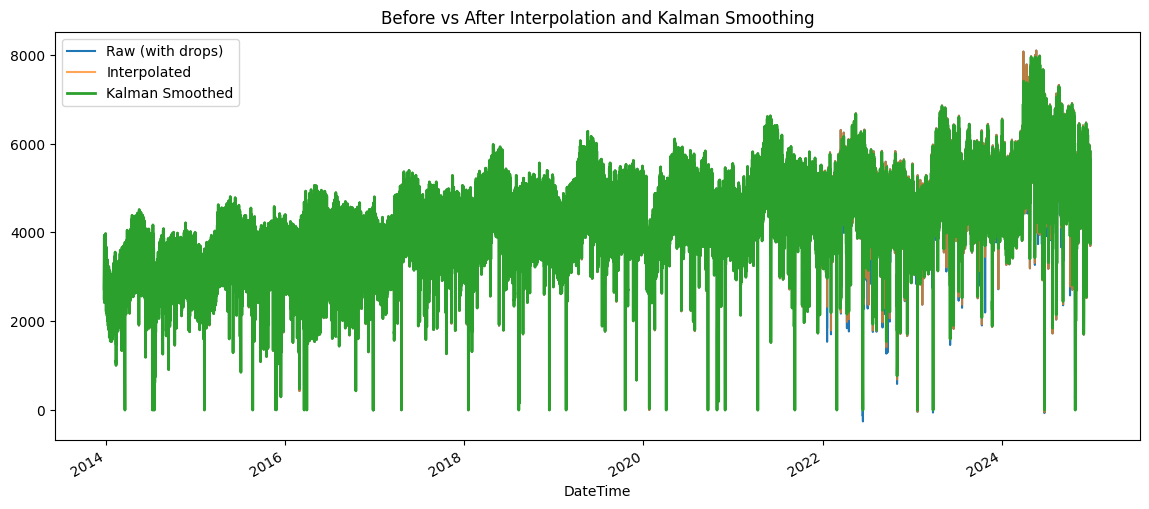

Done


In [43]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# --- Load data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Mark outages (≥20% drop vs. previous value) as missing ---
# Compute % change
pct_change = df["TOTAL"].pct_change()

# If the drop is 20% or more (i.e. <= -0.2), mark as NaN
df.loc[pct_change <= -0.1, "TOTAL"] = np.nan

# --- Step 2: Temporary fill for NaNs (linear interpolation) ---
observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# --- Step 3: Initialize Kalman Filter ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=observed.iloc[0],
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 4: Fit & smooth ---
smoothed_state_means, _ = kf.em(observed.values, n_iter=5).smooth(observed.values)

# --- Step 5: Replace TOTAL with smoothed values ---
df["TOTAL"] = smoothed_state_means

# --- Step 6: Save cleaned dataset ---
df.to_csv("Demand_with_Temperature_Kalman2.csv")

print("Done")


In [50]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# --- Load sample data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Detect outliers in TOTAL (z-score > 3) ---
z_scores = (df["TOTAL"] - df["TOTAL"].mean()) / df["TOTAL"].std()
outliers = np.abs(z_scores) > 3

# Mark outliers as NaN
df.loc[outliers, "TOTAL"] = np.nan

# --- Step 2: Kalman Filter setup ---
kf = KalmanFilter(
    transition_matrices=[1],       # simple random walk model
    observation_matrices=[1],
    initial_state_mean=df["TOTAL"].mean(),
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 3: Apply Kalman smoother (handles NaN automatically) ---
state_means, _ = kf.smooth(df["TOTAL"].values)
state_means = state_means.flatten()  # <-- flatten from (n,1) → (n,)

# Replace NaN and outliers with smoothed estimates
df["TOTAL_KF"] = df["TOTAL"].copy()
df["TOTAL_KF"].fillna(pd.Series(state_means, index=df.index), inplace=True)

# --- Step 4: Plot to visualize ---
# plt.figure(figsize=(12,6))
# plt.plot(df.index, state_means, label="Kalman Smoothed", color="red")
# plt.plot(df.index, df["TOTAL_KF"], label="TOTAL (fixed)", alpha=0.7)
# plt.plot(df.index, df["TOTAL"], "k.", label="TOTAL (with NaNs/outliers)", alpha=0.5)
# plt.legend()
# plt.title("Outlier Fix with Kalman Filter")
# plt.show()

# Save results
df.to_csv("Demand_with_Temperature_Kalman2.csv")


/tmp/ipykernel_2991806/2732983188.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TOTAL_KF"].fillna(pd.Series(state_means, index=df.index), inplace=True)


Loading CSV: 100%|██████████| 1157172/1157172 [00:03<00:00, 297895.11rows/s]



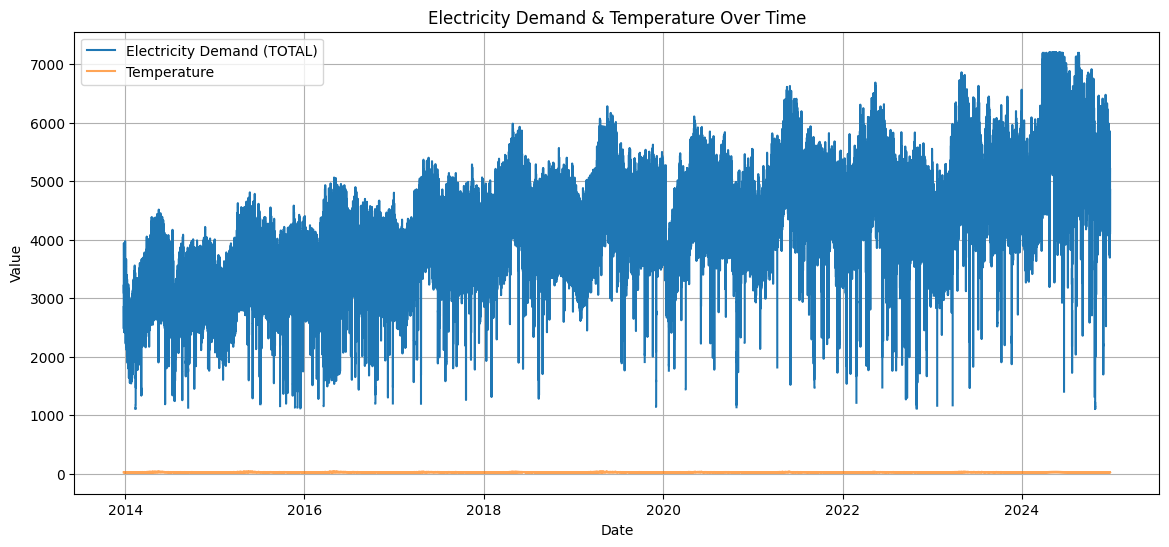

In [51]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature_Kalman2.csv"
chunksize = 50_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
